In [1]:
# Setup & load 
import numpy as np
import pandas as pd
import os
from numpy.linalg import lstsq
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sqlalchemy import create_engine

plt.rcParams.update({"figure.dpi": 140})
engine = create_engine("sqlite:///analytics_panel.sqlite")

# Load master view
panel = pd.read_sql("SELECT * FROM v_panel_all;", con=engine)

# Add log income (used in partials)
panel["log_gdppc"] = np.log(panel["current_usd"]).replace([np.inf, -np.inf], np.nan)

# Variable registry (by domain)
DOMAINS = {
    "Fertility": ["fertility_rate"], 
    "Marriage": ["married_percentage"],
    "GDP": ["log_gdppc", "current_usd", "annual_rate", "deflation"],
    "Employment": ["female_participation", "unemployment"],
    "Politics/Safety": ["CPI10", "CPI100", "WGI"],
}
ALL_VARS = sorted(set(sum(DOMAINS.values(), [])))

# Show first few rows with fertility + domains
display_cols = ["iso_code", "year"] + [c for c in ALL_VARS if c in panel.columns]
#print("Vars in panel:", display_cols)
panel[display_cols].head()


,iso_code,year,CPI10,CPI100,WGI,annual_rate,current_usd,deflation,female_participation,fertility_rate,log_gdppc,married_percentage,unemployment
0,ABW,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.567000,NaN,NaN,NaN
1,AFE,1960,NaN,NaN,NaN,NaN,186.121835,NaN,NaN,6.650310,5.226401,NaN,NaN
2,AFG,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.282000,NaN,NaN,NaN
3,AFW,1960,NaN,NaN,NaN,NaN,121.939925,NaN,NaN,6.468887,4.803529,NaN,NaN
4,AGO,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.708000,NaN,NaN,NaN


In [2]:
outfile = "Deliverable 1.1.1 complete panel view.csv"

panel.to_csv(outfile, index=False)

print(f"Saved panel to: {os.path.abspath(outfile)}")

Saved panel to: /Users/macbookpro/Capstone/Deliverable 1.1.1 complete panel view.csv


In [3]:
# Completeness overview
vars_all = [
    "married_percentage",
    "female_participation", "unemployment",
    "current_usd", "annual_rate", "deflation",
    "WGI", "CPI10", "CPI100"
]

# Overall non-null fraction
overall = panel[["fertility_rate"] + vars_all].notna().mean().sort_values(ascending=False)
print("Non-null fraction (overall):")
print((overall*100).round(1))

Non-null fraction (overall):
fertility_rate          94.4
current_usd             81.1
annual_rate             78.7
deflation               78.2
married_percentage      68.1
female_participation    45.8
unemployment            44.5
CPI100                   2.7
CPI10                    2.2
WGI                      1.5
dtype: float64


Coverage is strong for GDP and moderate for marriage. To avoid bias, I report n (datapoints), avoided imputation, split CPI into CPI10/CPI100, and cross-checked governance with WGI, plus within-country and partial controls. 

In [4]:
# Helpers 
STAR_THRESH = [(1e-6, "****"), (1e-4, "***"), (1e-2, "**"), (0.05, "*")]

def stars(p):
    for t, s in STAR_THRESH:
        if p < t: return s
    return ""

def corr_tests(df, x, y="fertility_rate", min_n=10):
    # keep only the two columns, replace inf with NaN, then drop rows with NaN
    sub = df[[y, x]].replace([np.inf, -np.inf], np.nan).dropna()

    n = len(sub)
    if n < min_n:
        return {"var": x, "n": int(n),
                "pearson": np.nan, "pearson_p": np.nan,
                "spearman": np.nan, "spearman_p": np.nan}

    # FORCE 1-D float arrays (prevents shape (n,2) issues)
    yv = sub[y].to_numpy(dtype=float).reshape(-1)
    xv = sub[x].to_numpy(dtype=float).reshape(-1)

    r_p, p_p = pearsonr(yv, xv)
    r_s, p_s = spearmanr(yv, xv)
    return {"var": x, "n": int(n),
            "pearson": float(r_p), "pearson_p": float(p_p),
            "spearman": float(r_s), "spearman_p": float(p_s)}


def demean_by_country(df, cols):
    out = df.copy()
    for c in cols:
        out[c] = out[c] - out.groupby("iso_code")[c].transform("mean")
    return out

def tidy_corr_table(df, vars_list, title):
    rows = [corr_tests(df, v) for v in vars_list if v in df.columns]
    out = pd.DataFrame(rows)
    out["abs_pearson"] = out["pearson"].abs()
    out["sig"] = out["pearson_p"].apply(stars)
    out["spearman_sig"] = out["spearman_p"].apply(stars)
    out.insert(0, "group", out["var"].map(
        {v: g for g, vs in DOMAINS.items() for v in vs}
    ))
    out = out.sort_values(["abs_pearson","n"], ascending=[False, False]).reset_index(drop=True)
    out.attrs["title"] = title
    return out


,group,var,n,pearson,pearson_p,spearman,spearman_p,abs_pearson,sig
0,Fertility,fertility_rate,16928,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,****
1,GDP,log_gdppc,14313,-0.779028,0.000000e+00,-0.806182,0.000000e+00,0.779028,****
2,Politics/Safety,CPI100,441,-0.592150,4.431201e-43,-0.646295,1.654795e-53,0.592150,****
3,Politics/Safety,CPI10,382,-0.483343,9.294564e-24,-0.555990,2.238960e-32,0.483343,****
4,GDP,current_usd,14313,-0.441411,0.000000e+00,-0.806182,0.000000e+00,0.441411,****
5,Marriage,married_percentage,11266,0.426064,0.000000e+00,0.384271,0.000000e+00,0.426064,****
6,Politics/Safety,WGI,270,-0.190101,1.701899e-03,-0.173353,4.277711e-03,0.190101,**
7,Employment,unemployment,7751,-0.121932,4.601028e-27,-0.165152,1.601575e-48,0.121932,****
8,Employment,female_participation,7986,0.098179,1.448453e-18,0.088141,3.003470e-15,0.098179,****
9,GDP,annual_rate,13880,-0.069156,3.448448e-16,-0.127040,4.914051e-51,0.069156,****


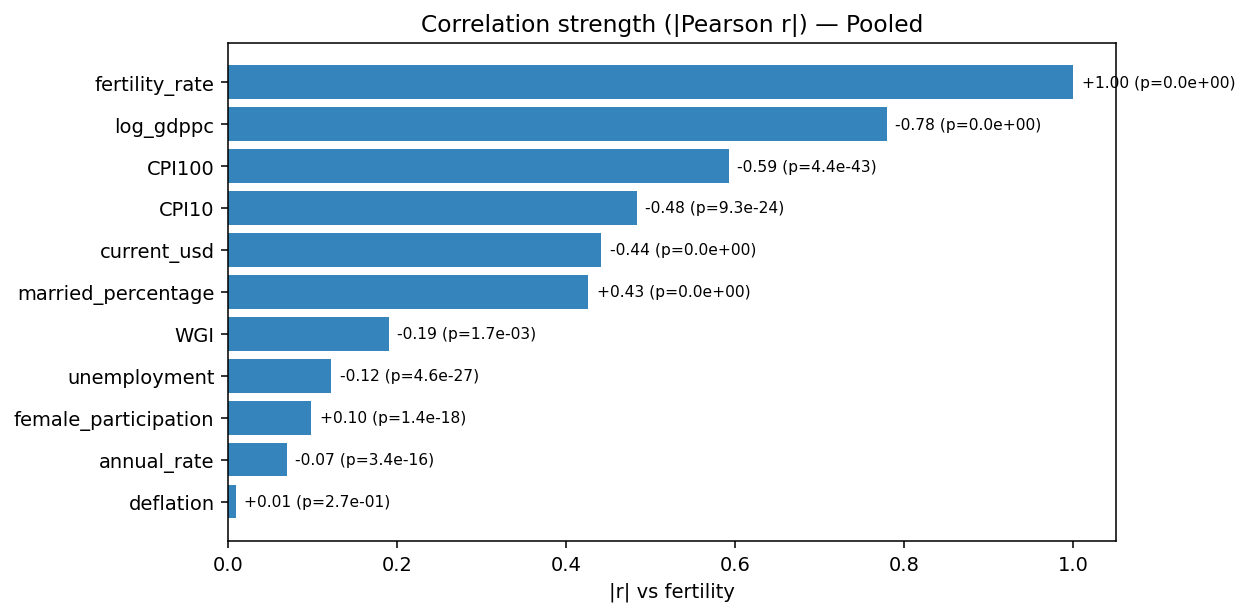

In [5]:
# Pooled correlations 
pooled_tbl = tidy_corr_table(panel, ALL_VARS, title="Pooled correlations")
display(pooled_tbl[["group","var","n","pearson","pearson_p","spearman","spearman_p","abs_pearson","sig"]])

# Visual: absolute Pearson by variable (ranked)
fig, ax = plt.subplots(figsize=(9,4.5))
ranked = pooled_tbl.sort_values("abs_pearson", ascending=True)
ax.barh(ranked["var"], ranked["abs_pearson"], alpha=0.9)
for i,(r,p) in enumerate(zip(ranked["pearson"], ranked["pearson_p"])):
    ax.text(ranked["abs_pearson"].iloc[i]+0.01, i,
            f"{r:+.2f} (p={p:.1e})", va="center", fontsize=8)
ax.set_title("Correlation strength (|Pearson r|) — Pooled")
ax.set_xlabel("|r| vs fertility")
plt.tight_layout()
plt.savefig("Deliverable 1.2.2 pooled correlation - bar graph.png", dpi=300)
plt.show()


In [6]:
outfile = "Deliverable 1.2.1 pooled correlation matrices.csv"
pooled_tbl[["group","var","n","pearson","pearson_p",
            "spearman","spearman_p","abs_pearson","sig"]].to_csv(outfile, index=False)

print(f"Saved to: {outfile}")

Saved to: Deliverable 1.2.1 pooled correlation matrices.csv


,group,var,n,pearson,pearson_p,spearman,spearman_p,abs_pearson,sig
0,GDP,log_gdppc,14313,-0.721322,0.000000e+00,-0.723611,0.000000e+00,0.721322,****
1,Marriage,married_percentage,11266,0.449693,0.000000e+00,0.469145,0.000000e+00,0.449693,****
2,GDP,current_usd,14313,-0.235877,3.587683e-180,-0.537510,0.000000e+00,0.235877,****
3,Politics/Safety,WGI,270,-0.043246,4.791669e-01,-0.049986,4.133261e-01,0.043246,
4,Employment,unemployment,7751,-0.039488,5.065128e-04,-0.016488,1.466580e-01,0.039488,**
5,Employment,female_participation,7986,-0.029895,7.546607e-03,-0.011716,2.951814e-01,0.029895,**
6,GDP,annual_rate,13880,0.019382,2.240176e-02,-0.019746,1.999677e-02,0.019382,*
7,Politics/Safety,CPI100,441,-0.014120,7.674659e-01,-0.045964,3.355375e-01,0.014120,
8,GDP,deflation,13784,0.010946,1.987658e-01,0.150144,2.608400e-70,0.010946,
9,Politics/Safety,CPI10,382,-0.004710,9.268939e-01,-0.006035,9.064105e-01,0.004710,


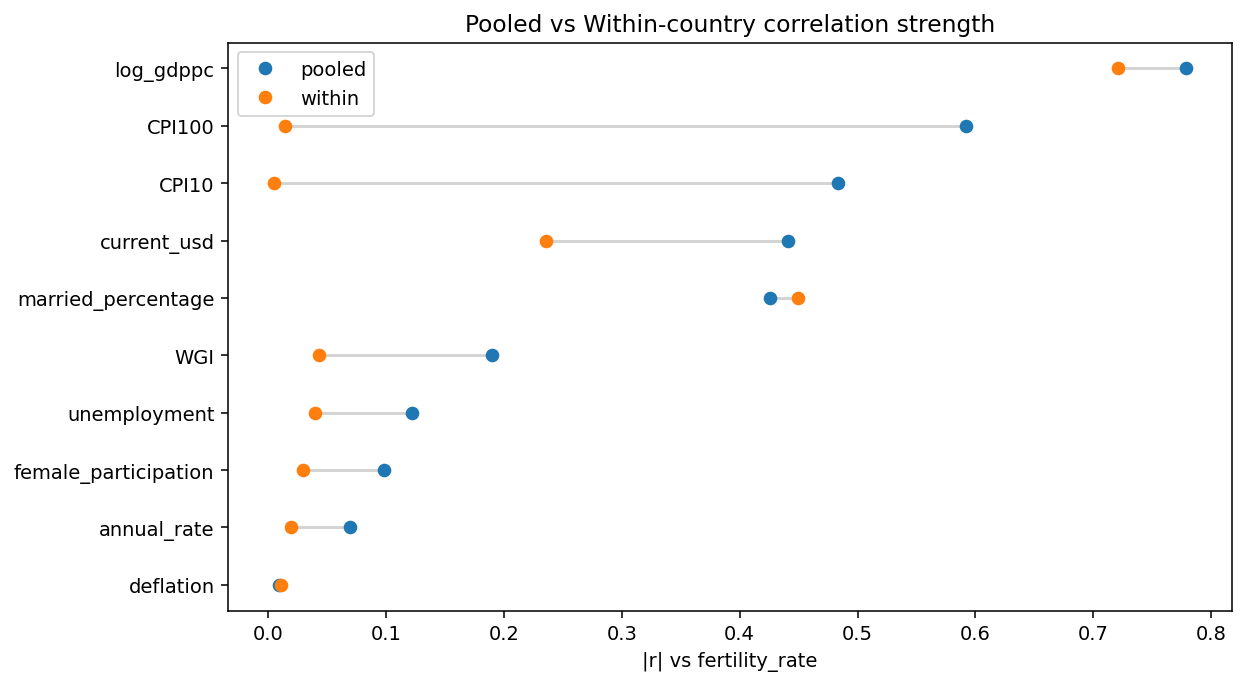

In [7]:
# Within-country correlations
Y_VAR = "fertility_rate"
X_VARS_W = [v for v in ALL_VARS if v in panel.columns and v != Y_VAR]

# Demean by country
panel_w = demean_by_country(panel[["iso_code","year"] + [Y_VAR] + X_VARS_W], [Y_VAR] + X_VARS_W)

# Correlations
within_tbl = tidy_corr_table(panel_w, X_VARS_W, title="Within-country correlations")
display(within_tbl[["group","var","n","pearson","pearson_p","spearman","spearman_p","abs_pearson","sig"]])

# Compare pooled vs within (lollipop)
m = (pooled_tbl[["var","abs_pearson"]].rename(columns={"abs_pearson":"pooled_|r|"})
       .merge(within_tbl[["var","abs_pearson"]].rename(columns={"abs_pearson":"within_|r|"}),
              on="var", how="inner")
       .dropna()
       .sort_values("pooled_|r|"))

fig, ax = plt.subplots(figsize=(9,5))
ax.hlines(y=m["var"], xmin=m["within_|r|"], xmax=m["pooled_|r|"], color="lightgray")
ax.plot(m["pooled_|r|"], m["var"], "o", label="pooled")
ax.plot(m["within_|r|"], m["var"], "o", label="within")
ax.set_xlabel(f"|r| vs {Y_VAR}")
ax.set_title("Pooled vs Within-country correlation strength")
ax.legend()

fig.tight_layout()
fig.savefig("Deliverable 1.3.2 pooled vs within - lollipop.png", dpi=300)
plt.show()


In [8]:
outfile = "Deliverable 1.3.1 demeaned and first-diff models.csv"
within_tbl[["group","var","n","pearson","pearson_p",
            "spearman","spearman_p","abs_pearson","sig"]].to_csv(outfile, index=False)

print(f"Saved to: {outfile}")

Saved to: Deliverable 1.3.1 demeaned and first-diff models.csv


,var,n,pearson,pearson_p,spearman,spearman_p
6,CPI10_lag1,382,-0.484985,6.242219e-24,-0.560289,5.910401e-33
7,CPI10_lag2,382,-0.488832,2.436725e-24,-0.568207,4.829639e-34
8,CPI10_lag3,382,-0.494008,6.743701e-25,-0.577184,2.597570e-35
9,CPI100_lag1,403,-0.604324,1.756259e-41,-0.660381,7.841848e-52
10,CPI100_lag2,365,-0.614894,2.465943e-39,-0.674703,8.217048e-50
11,CPI100_lag3,327,-0.620807,3.138875e-36,-0.685779,9.199895e-47
12,WGI_lag1,259,-0.190285,2.100204e-03,-0.176008,4.495949e-03
13,WGI_lag2,248,-0.191527,2.453476e-03,-0.177487,5.059302e-03
14,WGI_lag3,237,-0.194735,2.604471e-03,-0.182114,4.918266e-03
15,female_participation_lag1,7754,0.106041,7.785512e-21,0.093079,2.161973e-16


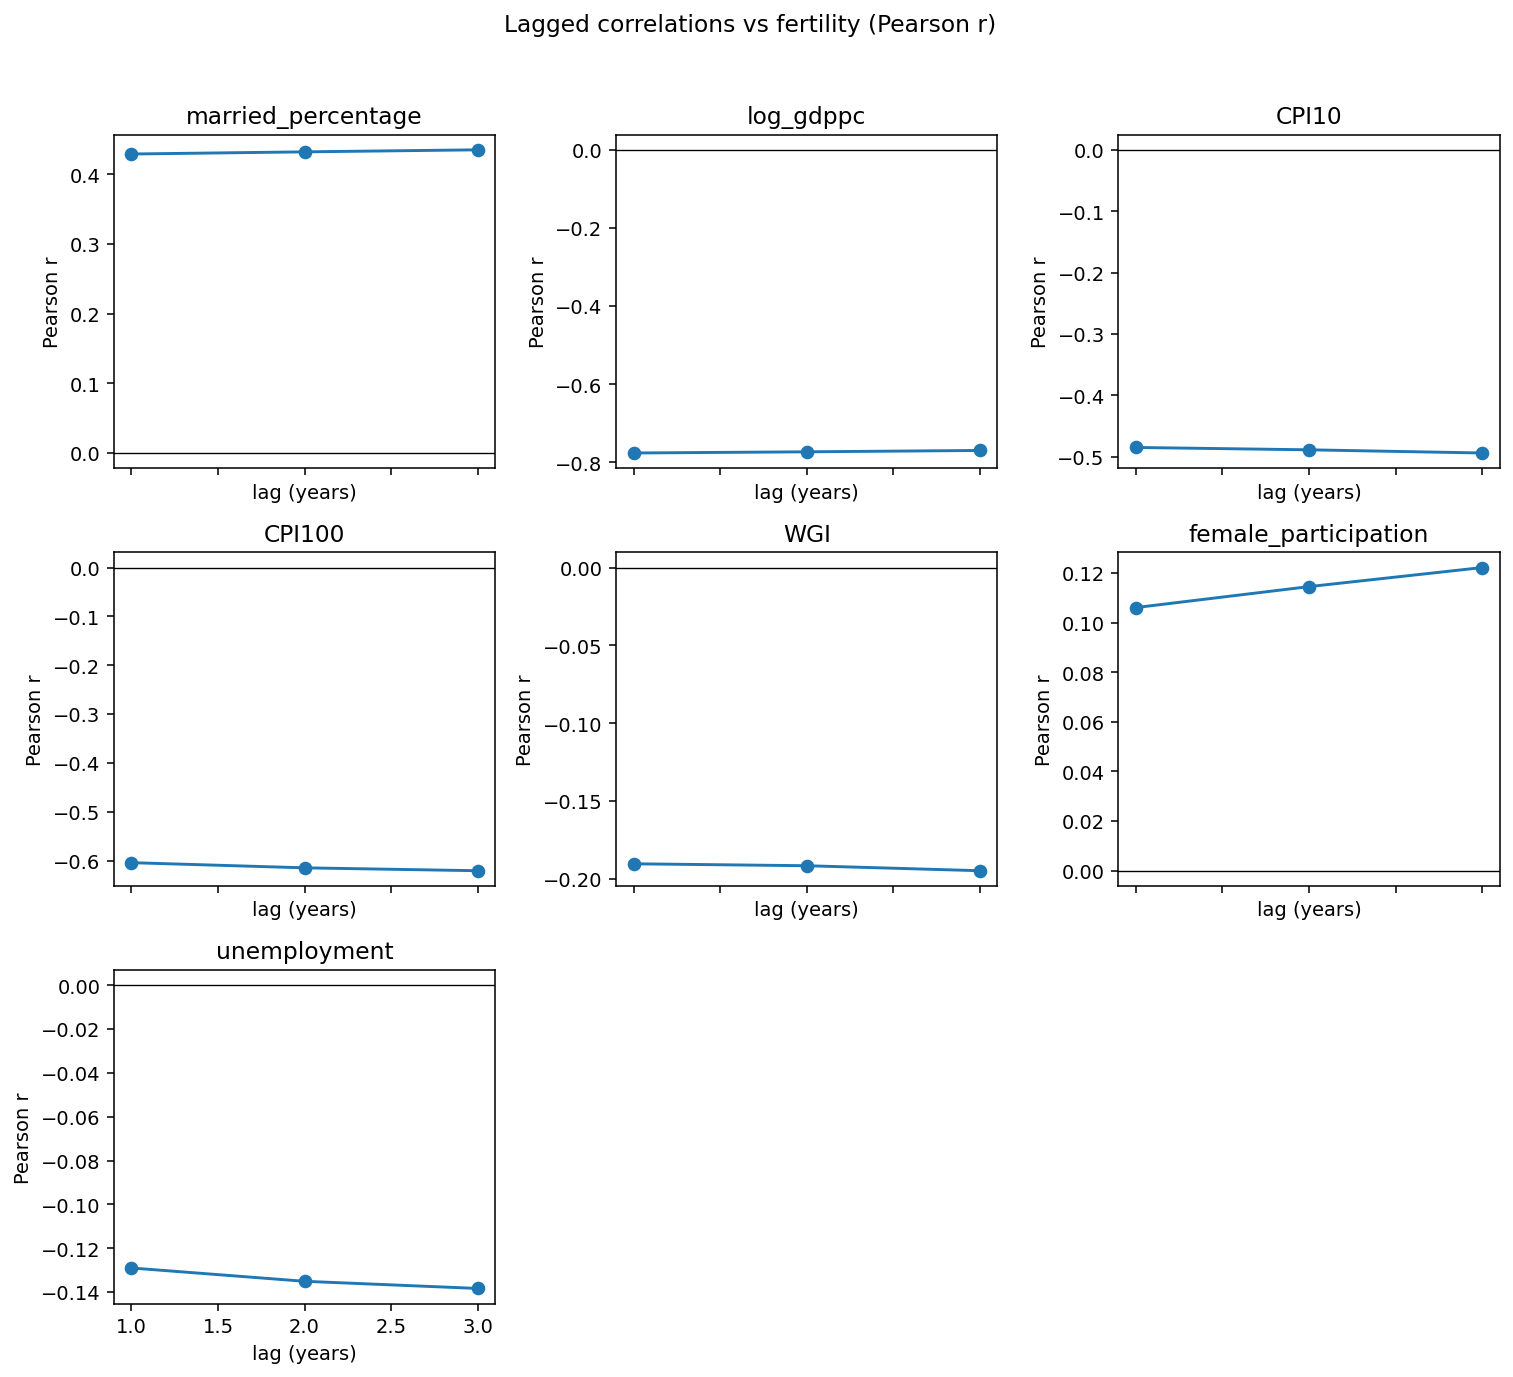

In [9]:
# Lags
KEY_LAG_VARS = ["married_percentage", "log_gdppc", "CPI10", "CPI100", "WGI",
                "female_participation", "unemployment"]

df = panel.sort_values(["iso_code","year"]).copy()
for v in KEY_LAG_VARS:
    if v in df.columns:
        for k in (1,2,3):
            df[f"{v}_lag{k}"] = df.groupby("iso_code")[v].shift(k)

lag_rows = []
for v in KEY_LAG_VARS:
    if v in panel.columns:
        for k in (1,2,3):
            col = f"{v}_lag{k}"
            if col in df.columns:
                lag_rows.append(corr_tests(df, col))
lag_tbl = pd.DataFrame(lag_rows)
lag_tbl["var_root"] = lag_tbl["var"].str.replace(r"_lag\d+$","",regex=True)
lag_tbl["lag"] = lag_tbl["var"].str.extract(r"_lag(\d+)").astype(float)
lag_tbl = lag_tbl.dropna(subset=["lag"])
display(lag_tbl.sort_values(["var_root","lag"])[["var","n","pearson","pearson_p","spearman","spearman_p"]].head(20))

# Visual: line of r by lag for each variable (small multiples)
vars_present = lag_tbl["var_root"].unique().tolist()
ncols = 3
nrows = int(np.ceil(len(vars_present)/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(11, 3.2*nrows), sharex=True)
axes = axes.ravel()

for i, v in enumerate(vars_present):
    sub = lag_tbl[lag_tbl["var_root"]==v].sort_values("lag")
    ax = axes[i]
    ax.plot(sub["lag"], sub["pearson"], marker="o")
    ax.axhline(0, color="k", linewidth=0.7)
    ax.set_title(v)
    ax.set_xlabel("lag (years)")
    ax.set_ylabel("Pearson r")
for j in range(i+1, len(axes)):
    axes[j].axis("off")
plt.suptitle("Lagged correlations vs fertility (Pearson r)", y=1.02, fontsize=12)
plt.tight_layout(); plt.show()
fig.savefig("lag_graphs.png", dpi=160, bbox_inches="tight")


In [10]:
# Partials | key controls 
def partial_corr(df, x, y, z, min_n=10):
    # keep only relevant cols, coerce to float, replace infs, drop NaNs
    sub = (df[[x, y, z]]
           .apply(pd.to_numeric, errors="coerce")
           .replace([np.inf, -np.inf], np.nan)
           .dropna())

    n = len(sub)
    if n < min_n:
        return {"x": x, "y": y, "z": z, "n": int(n),
                "partial_r": np.nan, "partial_p": np.nan}

    # force 1-D float arrays for regression
    xv = sub[x].to_numpy(dtype=float).reshape(-1)
    yv = sub[y].to_numpy(dtype=float).reshape(-1)
    zv = sub[z].to_numpy(dtype=float).reshape(-1)

    # regress y on z, x on z (degree=1) → residuals
    by, ay = np.polyfit(zv, yv, 1)   # slope, intercept
    bx, ax = np.polyfit(zv, xv, 1)

    y_res = yv - (by * zv + ay)
    x_res = xv - (bx * zv + ax)

    r, p = pearsonr(y_res, x_res)
    return {"x": x, "y": y, "z": z, "n": int(n),
            "partial_r": float(r), "partial_p": float(p)}


partial_rows = []

Y = "fertility_rate"
Z = "log_gdppc"

# A) Does each predictor add signal beyond income? (| log_gdppc)
for v in [v for v in ALL_VARS if v in panel.columns and v not in (Y, Z, "current_usd")]:
    partial_rows.append(partial_corr(panel, x=v, y=Y, z=Z))

# B) For GDP level, does it add signal beyond marriage? (| marriage)
if "married_percentage" in panel.columns:
    partial_rows.append(partial_corr(panel, x=Z, y=Y, z="married_percentage"))

partials_tbl = pd.DataFrame(partial_rows)
partials_tbl["sig"] = partials_tbl["partial_p"].apply(stars)
display(partials_tbl.sort_values("partial_r"))


,x,y,z,n,partial_r,partial_p,sig
8,log_gdppc,fertility_rate,married_percentage,9941,-0.679962,0.000000e+00,****
7,unemployment,fertility_rate,log_gdppc,7602,-0.132480,4.116892e-31,****
3,annual_rate,fertility_rate,log_gdppc,13784,-0.110820,6.367438e-39,****
1,CPI100,fertility_rate,log_gdppc,441,-0.072884,1.264486e-01,
0,CPI10,fertility_rate,log_gdppc,382,-0.038198,4.566369e-01,
4,deflation,fertility_rate,log_gdppc,13719,-0.035518,3.167375e-05,***
2,WGI,fertility_rate,log_gdppc,260,-0.019006,7.603596e-01,
5,female_participation,fertility_rate,log_gdppc,7823,0.094616,5.028473e-17,****
6,married_percentage,fertility_rate,log_gdppc,9941,0.187086,5.442435e-79,****


In [11]:
outfile = "Deliverable 1.4.1 partial correlations controlling for GDP.csv"
partials_tbl[["x","y","z","n","partial_r","partial_p","sig"]].to_csv(outfile, index=False)

print(f"Saved to: {outfile}")

Saved to: Deliverable 1.4.1 partial correlations controlling for GDP.csv


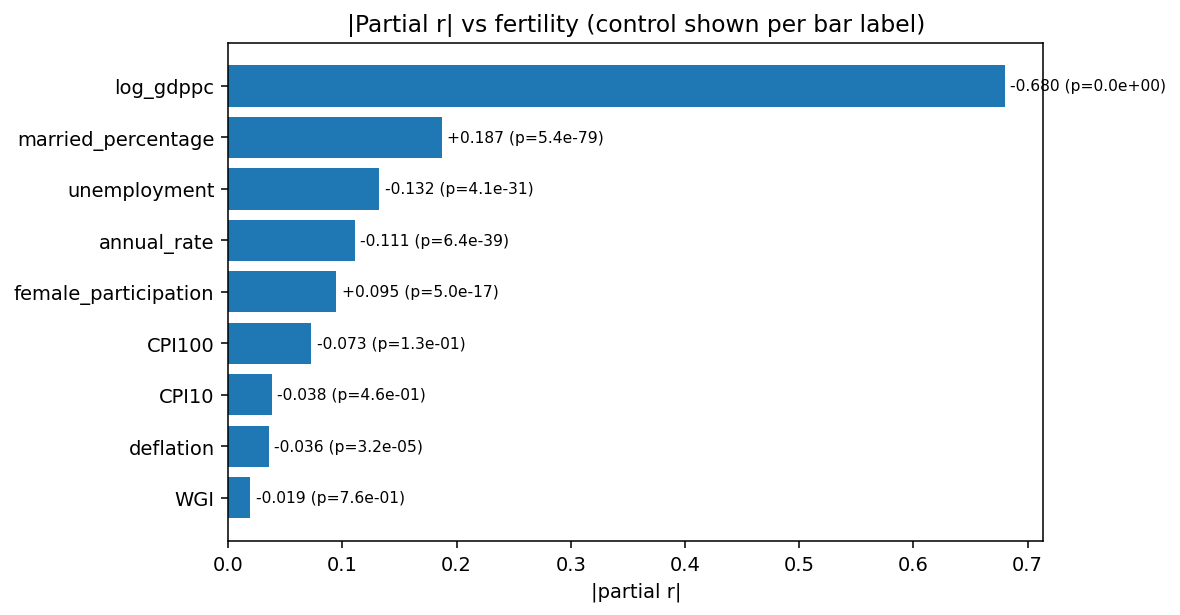

In [12]:
# Visual: |partial r| ranking
pt = partials_tbl.dropna(subset=["partial_r"]).copy()
pt["abs_partial"] = pt["partial_r"].abs()
pt = pt.sort_values("abs_partial", ascending=True)

fig, ax = plt.subplots(figsize=(8.5, 4.5))
ax.barh(pt["x"], pt["abs_partial"])
for i,(r,p) in enumerate(zip(pt["partial_r"], pt["partial_p"])):
    ax.text(pt["abs_partial"].iloc[i]+0.005, i, f"{r:+.3f} (p={p:.1e})", va="center", fontsize=8)
ax.set_title("|Partial r| vs fertility (control shown per bar label)")
ax.set_xlabel("|partial r|")
plt.tight_layout(); plt.show()


Saved comparison table : Deliverable 1.4.2 comparative results across models.csv


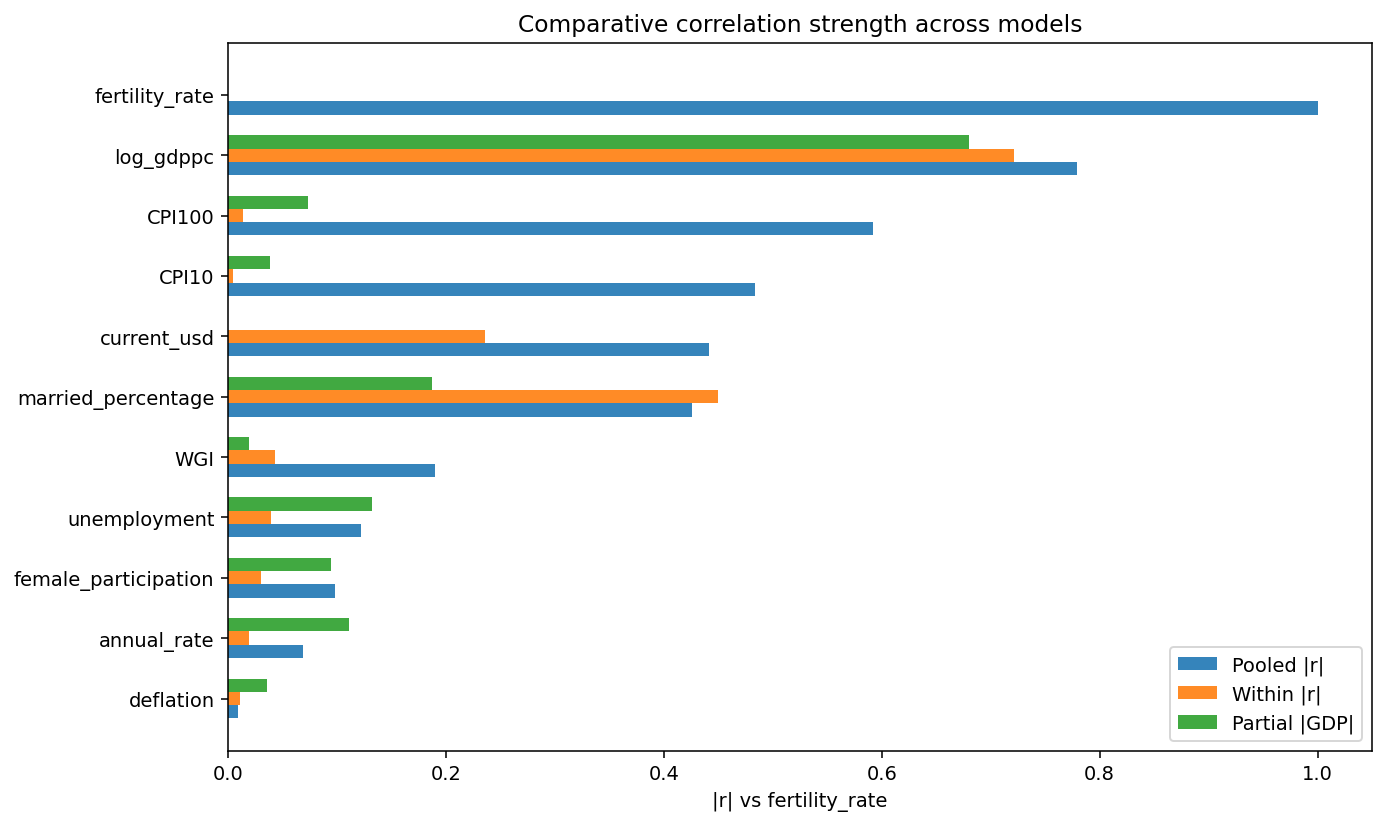

In [13]:
Y_VAR = "fertility_rate"  # for axis label only

# 1) Build comparison table
comp = (
    pooled_tbl[["var","abs_pearson"]].rename(columns={"abs_pearson":"Pooled |r|"})
    .merge(
        within_tbl[["var","abs_pearson"]].rename(columns={"abs_pearson":"Within |r|"}),
        on="var", how="outer"
    )
    .merge(
        partials_tbl.rename(columns={"x":"var"})[["var","partial_r"]]
                   .assign(**{"Partial |GDP|": lambda d: d["partial_r"].abs()} )[["var","Partial |GDP|"]],
        on="var", how="outer"
    )
)

# Optional: add domain column if you have DOMAINS
domain_map = {v:g for g, vs in DOMAINS.items() for v in vs}
comp["Domain"] = comp["var"].map(domain_map)

# Order by pooled strength (fallback to within/partial if pooled is NaN)
comp["_order"] = comp["Pooled |r|"].fillna(-1)
comp = comp.sort_values("_order", ascending=False).drop(columns="_order")

# Save table
comp_outfile = "Deliverable 1.4.2 comparative results across models.csv"
comp.to_csv(comp_outfile, index=False)
print(f"Saved comparison table : {comp_outfile}")

# 2) Visual: grouped horizontal bars for top N variables
TOP_N = 12  # adjust as needed
plot_df = comp.head(TOP_N).fillna(0.0)

fig, ax = plt.subplots(figsize=(10, 6))

y = np.arange(len(plot_df))
bar_h = 0.22

ax.barh(y + bar_h*1, plot_df["Pooled |r|"], height=bar_h, label="Pooled |r|", alpha=0.9)
ax.barh(y + bar_h*0, plot_df["Within |r|"], height=bar_h, label="Within |r|", alpha=0.9)
ax.barh(y - bar_h*1, plot_df["Partial |GDP|"], height=bar_h, label="Partial |GDP|", alpha=0.9)

ax.set_yticks(y)
ax.set_yticklabels(plot_df["var"])
ax.invert_yaxis()  # strongest at top
ax.set_xlabel(f"|r| vs {Y_VAR}")
ax.set_title("Comparative correlation strength across models")
ax.legend(loc="lower right")

fig.tight_layout()
fig.savefig("Deliverable 1.4.2 comparative results across models.png", dpi=300)
plt.show()



In [14]:
# Compact dashboard table 
def pick(tbl, var):
    row = tbl[tbl["var"]==var].iloc[0] if var in tbl["var"].values else None
    if row is None: return None
    return f"{row['pearson']:+.3f}"

vars_show = ["married_percentage","log_gdppc","current_usd","annual_rate","deflation",
             "CPI10","CPI100","WGI","female_participation","unemployment"]

dash = []
for v in vars_show:
    pooled = pick(pooled_tbl, v)
    within = pick(within_tbl, v)
    dash.append({"var": v, "pooled": pooled, "within": within})
dashboard = pd.DataFrame(dash)
display(dashboard)


,var,pooled,within
0,married_percentage,+0.426,+0.450
1,log_gdppc,-0.779,-0.721
2,current_usd,-0.441,-0.236
3,annual_rate,-0.069,+0.019
4,deflation,+0.009,+0.011
5,CPI10,-0.483,-0.005
6,CPI100,-0.592,-0.014
7,WGI,-0.190,-0.043
8,female_participation,+0.098,-0.030
9,unemployment,-0.122,-0.039


In [15]:
# Robustness A: Within-country with per-variable minimum-years filter 

VARS = [
    "log_gdppc", "current_usd",
    "married_percentage",
    "CPI10", "CPI100", "WGI",
    "female_participation", "unemployment",
    "annual_rate", "deflation",
]

def within_country_corr_per_var(df, x, min_years):
    # Keep only columns needed for this variable's test
    d = df[["iso_code", "year", "fertility_rate", x]].dropna(subset=["fertility_rate", x]).copy()
    if d.empty:
        return np.nan, np.nan, 0, 0

    # Count years per country for THIS pair (fertility & x)
    yrs = d.groupby("iso_code")["year"].nunique()
    keep_countries = yrs[yrs >= min_years].index
    d = d[d["iso_code"].isin(keep_countries)]
    n_countries = d["iso_code"].nunique()
    if d.empty or n_countries == 0:
        return np.nan, np.nan, 0, 0

    # Demean within country
    d["_x"] = d[x] - d.groupby("iso_code")[x].transform("mean")
    d["_y"] = d["fertility_rate"] - d.groupby("iso_code")["fertility_rate"].transform("mean")
    d = d.dropna(subset=["_x","_y"])
    if d.empty:
        return np.nan, np.nan, 0, n_countries

    # Pearson on residuals
    r_p = np.corrcoef(d["_x"], d["_y"])[0, 1]
    # Spearman on residuals (rank of residuals)
    r_s = pd.Series(d["_x"]).rank().corr(pd.Series(d["_y"]).rank(), method="pearson")
    return float(r_p), float(r_s), int(len(d)), int(n_countries)

rows = []
for K in (10, 15):
    for v in VARS:
        rp, rs, n_rows, n_cty = within_country_corr_per_var(panel, v, min_years=K)
        rows.append({
            "min_years": K,
            "var": v,
            "countries_used": n_cty,
            "rows_used": n_rows,
            "pearson_r_within": rp,
            "spearman_r_within": rs,
            "abs_r": np.nan if pd.isna(rp) else abs(rp),
        })

robust_within = (
    pd.DataFrame(rows)
      .sort_values(["min_years", "abs_r"], ascending=[True, False])
      .drop(columns=["abs_r"])
)
print("Within-country correlations with per-variable ≥K-year filter (sorted by |Pearson r| within K):")
robust_within


Within-country correlations with per-variable ≥K-year filter (sorted by |Pearson r| within K):


,min_years,var,countries_used,rows_used,pearson_r_within,spearman_r_within
0,10,log_gdppc,260,14301,-0.744044,-0.761179
2,10,married_percentage,209,11266,0.454988,0.488411
1,10,current_usd,260,14301,-0.242999,-0.559247
5,10,WGI,12,197,-0.095004,-0.192569
3,10,CPI10,22,256,-0.089168,-0.052025
4,10,CPI100,34,408,-0.084322,-0.060133
7,10,unemployment,235,7751,-0.061187,-0.023176
6,10,female_participation,235,7986,-0.042000,-0.030371
8,10,annual_rate,260,13866,0.019710,-0.010198
9,10,deflation,260,13777,0.011547,0.121873


In [16]:
outfile = "Deliverable 1.5.1 minimum year threshold.csv"
robust_within.to_csv(outfile, index=False)

print(f"Saved to: {outfile}")

Saved to: Deliverable 1.5.1 minimum year threshold.csv


In [17]:
# Robustness B: Winsorize 1% tails and recompute partials | log-GDPpc 

# variables to partial (exclude the control itself)
PARTIAL_VARS = [
    "married_percentage",
    "current_usd",      # expect to shrink relative to log scale
    "CPI10", "CPI100", "WGI",
    "female_participation", "unemployment",
    "annual_rate", "deflation",
]

def winsorize(s, p=0.01):
    if s.dropna().empty: 
        return s
    lo, hi = s.quantile([p, 1-p])
    return s.clip(lower=lo, upper=hi)

def partial_corr_xy_z(df, x, y, z):
    """Residualize x and y on z (with intercept), then Pearson corr of residuals."""
    d = df[[x, y, z]].dropna()
    if d.empty:
        return np.nan, 0
    Xz = np.column_stack([d[z].to_numpy(float), np.ones(len(d))])
    # residualize x
    bx, *_ = lstsq(Xz, d[x].to_numpy(float), rcond=None)
    rx = d[x].to_numpy(float) - Xz @ bx
    # residualize y
    by, *_ = lstsq(Xz, d[y].to_numpy(float), rcond=None)
    ry = d[y].to_numpy(float) - Xz @ by
    r = np.corrcoef(rx, ry)[0,1]
    return float(r), int(len(d))

# Build a winsorized copy for all variables we’ll touch
cols_needed = ["fertility_rate", "log_gdppc"] + PARTIAL_VARS
W = panel[["iso_code","year"] + cols_needed].copy()
for c in cols_needed:
    W[c] = winsorize(W[c].astype(float), p=0.01)

rows = []
for v in PARTIAL_VARS:
    r, n = partial_corr_xy_z(W, v, "fertility_rate", "log_gdppc")
    rows.append({
        "var": v, "n": n, "partial_r_winsor_1pct": r, "abs_r": abs(r) if pd.notna(r) else np.nan
    })
partials_winsor = pd.DataFrame(rows).sort_values("abs_r", ascending=False).drop(columns=["abs_r"])
print("Partial correlations with 1% winsorization (controls: log_gdppc):")
partials_winsor


Partial correlations with 1% winsorization (controls: log_gdppc):


,var,n,partial_r_winsor_1pct
1,current_usd,14313,0.251679
0,married_percentage,9941,0.179485
7,annual_rate,13784,-0.163023
6,unemployment,7602,-0.129352
8,deflation,13719,-0.095522
5,female_participation,7823,0.094951
3,CPI100,441,-0.057649
2,CPI10,382,-0.033384
4,WGI,260,-0.018890


In [18]:
outfile = "Deliverable 1.5.1 1% winsorization.csv"
partials_winsor.to_csv(outfile, index=False)

print(f"Saved to: {outfile}")

Saved to: Deliverable 1.5.1 1% winsorization.csv
